<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Parameters' Initialization
</h1><br>

There are three kinds of optimization algorithms:
- Optimization algorithm that is not iterative and simply solves for one point.
- Optimization algorithm that is iterative in nature and converges to acceptable solution regradless of the parameters initialization such as gradient descent applied to logistic regression.
- Optimization algorithm that is iterative in nature and applied to a set of problems that have non-convex cost functions such neural networks. Therefore, parameters' initialization plays a critical role in speeding up convergence and achieving lower error rates.

In this notebook, we'll look at three different cases of parameters' initialization and see how this affects the error rate:
- Initialize all weights to zero.
- Initialize weights to random values from standard normal distribution or uniform distribution and multiply it by a scalar such as 10.
- Initialize weights based on:
    - Xavier recommendation
    - Kaiming He recommendation
    
Regarding forward propagation and backward propagation, we'll use the functions we wrote in the "Coding Deep Neural Network from Scratch" notebook. So we'll import those functions to use them in the final model.
To illustrate the above cases, we'll use the cats vs dogs dataset which consists of 50 images for cats and 50 images for dogs. Each image is 150 pixels x 150 pixels on RGB color scale. Therefore, we would have 67,500 features where each column in the input matrix would be one image which means our input data would have 67,500 x 100 dimension. Let's first load the data and show a sample of two images before we start the helper functions.

In [1]:
# Loading packages
import os as os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (12, 6)

The original shape: (100, 150, 150, 3)
The transformed shape: (67500, 100)


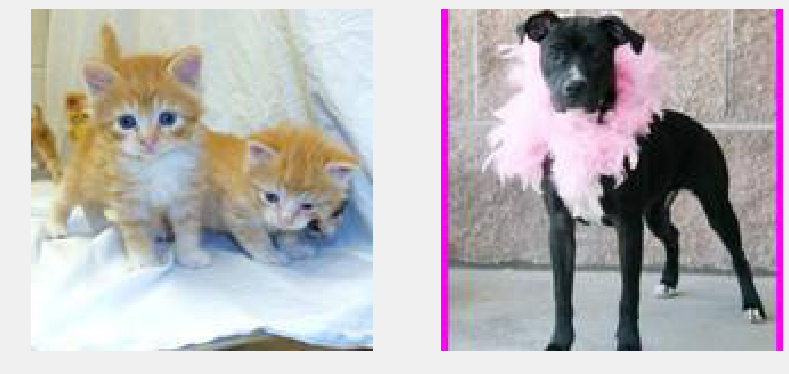

In [2]:
# set up the path
os.chdir("../data/")

# get all file names to iterate over all of them
image_list_names = os.listdir()[1:]

# loading images
X = []

for img in image_list_names:
    if img.startswith("."):
        pass
    
    else:
        temp = np.array(plt.imread(img))
        X.append(temp)
        
# convert to numpy array
X = np.array(X)
print("The original shape: {}".format(X.shape))
# show a sample of of a cat and a dog image
index_cat = 10; index_dog = 70
plt.subplot(1, 2, 1)
plt.imshow(X[index_cat])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(X[index_dog])
plt.axis("off");

# Derive true label vector
Y = np.zeros((1, 100))

for i, img in enumerate(image_list_names):
    if img.startswith("cat"):
        Y[:, i] = 1
        
    elif img.startswith("dog"):
        Y[:, i] = 0
        
# reshape X
num_pix = X.shape[1]
m = X.shape[0]
X = X.reshape(m, -1).T
print("The transformed shape: {}".format(X.shape))

# standarize the data
X = X / 255

We'll write now all the helper functions that will help us initialize weights based on different methods as well as writing L-layer model that we'll be using to train our neural network.

In [3]:
def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    Returns:
    parameters -- python dictionary containing all parameters Wl, bl
    """
    np.random.seed(1)               # to get consistent output
    parameters = {}                 # initialize parameters dictionary
    L = len(layers_dims)            # number of layers in the network

    for l in range(1, L):
        parameters["W" + str(l)] = np.zeros((layers_dims[l], layers_dims[l - 1]))
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters


def initialize_parameters_random(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    Returns:
    parameters -- python dictionary containing all parameters Wl, bl
    """
    np.random.seed(1)               # to get consistent output
    parameters = {}                 # initialize parameters dictionary
    L = len(layers_dims)            # number of layers in the network

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters


def initialize_parameters_he_xavier(layers_dims, initialization_method="he"):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    initialization_method -- string specify the initialization method to be used:
                     "he", "xavier"
    Returns:
    parameters -- python dictionary containing all parameters Wl, bl
    """
    np.random.seed(1)               # to get consistent output
    parameters = {}                 # initialize parameters dictionary
    L = len(layers_dims)            # number of layers in the network

    if initialization_method == "he":
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(
                layers_dims[l],
                layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    elif initialization_method == "xavier":
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(
                layers_dims[l],
                layers_dims[l - 1]) * np.sqrt(1 / layers_dims[l - 1])
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters

In [4]:
# Importing all helper functions needed
os.chdir("../scripts/")
from coding_deep_neural_network_from_scratch import *


def model(X, Y, layers_dims, learning_rate=0.01, num_iterations=1000,
          print_cost=True, hidden_layers_activation_fn="relu",
          initialization_method="he"):
    """
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size.
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    hidden_layers_activation_fn -- activation function to be used on hidden 
                                   layers, string: "tanh", "relu"
    initialization_method -- flag to choose which initialization to use
                             ("zeros","random", "he", or "xavier")
    Returns:
    parameters -- parameters learnt by the model.
    """
    # to get consistent results
    np.random.seed(1)
    
    # initialize cost list
    cost_list = []

    # initialize parameters
    if initialization_method == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)

    elif initialization_method == "random":
        parameters = initialize_parameters_random(layers_dims)

    else:
        parameters = initialize_parameters_he_xavier(
            layers_dims, initialization_method)

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, Y)
        
        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, Y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print("The cost after {} iterations is: {}".format(i + 1, cost))

        if i % 100 == 0:
            cost_list.append(cost)
        
    # plot the cost curve
    plt.plot(cost_list)
    plt.ylabel("Cost")
    plt.title(
        "Cost curve: learning rate = {} and {} initialization method".format(
            learning_rate, initialization_method))
    
    return parameters


def accuracy(X, parameters, Y, activation_fn="relu"):
    """
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    parameters -- python dictionary containing all learnt parameters
    Y -- true "label" vector of shape (1, number of examples)
    activation_fn -- activation function to be used on hidden 
                     layers, string: "tanh", "relu"

    Returns:
    accuracy -- accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs > 0.5) * 1
    accuracy = np.mean(labels == Y) * 100

    return "The accuracy rate is: {:.2f}%.".format(accuracy)

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Initializing all weights to zero
</h2>

Here, we'll initialize all weight matrices and biases to zeros and see how this would affect the error rate as well as the learning parameters. Below is the cost curve:

The cost after 100 iterations is: 0.6931471805599453
The cost after 200 iterations is: 0.6931471805599453
The cost after 300 iterations is: 0.6931471805599453
The cost after 400 iterations is: 0.6931471805599453
The cost after 500 iterations is: 0.6931471805599453
The cost after 600 iterations is: 0.6931471805599453
The cost after 700 iterations is: 0.6931471805599453
The cost after 800 iterations is: 0.6931471805599453
The cost after 900 iterations is: 0.6931471805599453
The cost after 1000 iterations is: 0.6931471805599453


'The accuracy rate is: 50.00%.'

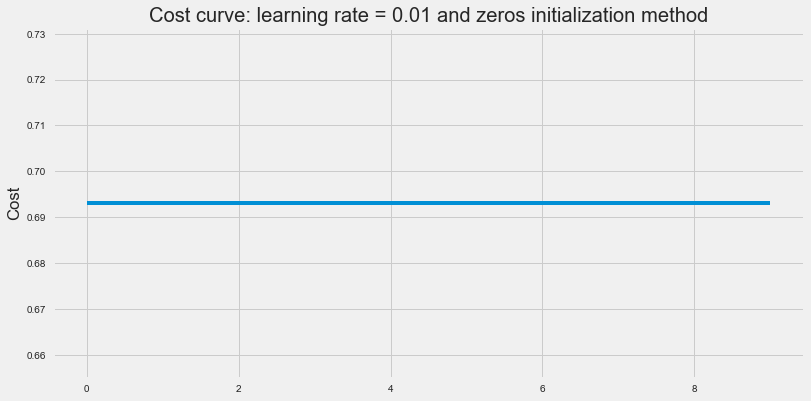

In [5]:
# train NN with zeros initialization weights
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh", initialization_method="zeros")

accuracy(X, parameters, Y,"tanh")

As the cost curve shows, the neural network didn't learn anything! That is because of symmetry between all neurons which leads to all neurons have the same update on every iteration. Therefore, regradless of how many iterations we run the optimization algorithms, all the neurons would still get the same update and no learning would happen. As a result, we must **break symmetry** when initializing weights so that the model would start learning on each update of gradient descent.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Initializing weights with big random values
</h2>

There is no big difference if the random values are initialized from standard normal distribution or uniform distribution so we'll use standard normal distribution in our examples. Also, we'll multiply the random values by a big number such as 10 to show that initializing weights to big values may cause our optimization to diverge. Let's now train our neural network where all weight matrices have been intitialized using the following formula:
`np.random.randn() * 10`

The cost after 100 iterations is: 1.2413142077549013
The cost after 200 iterations is: 1.1258751902393416
The cost after 300 iterations is: 1.0989052435267657
The cost after 400 iterations is: 1.084096647128233
The cost after 500 iterations is: 1.0706953292105978
The cost after 600 iterations is: 1.0574847320236294
The cost after 700 iterations is: 1.044316870888922
The cost after 800 iterations is: 1.031157857251139
The cost after 900 iterations is: 1.0179838815204902
The cost after 1000 iterations is: 1.004767088515343


'The accuracy rate is: 55.00%.'

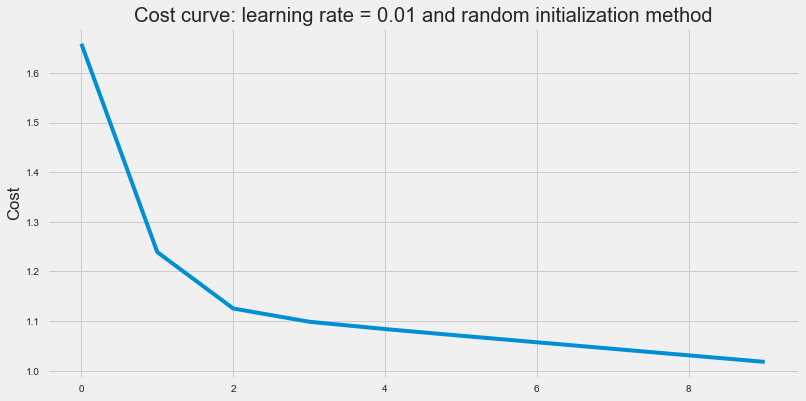

In [6]:
# train NN with random initialization weights
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh", initialization_method="random")

accuracy(X, parameters, Y,"tanh")

Random initialization here is helping but still the cost function has high value and may take long time to converge and achive a significantly low value.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Initializing weights based on He and Xavier recommendations
</h2>

- Kaiming He method is best applied when activation function applied on hidden layers is Rectified Linear Unit (ReLU). so that the weight on each hidden layer would have the following variance: $$var(W^l) = \frac{2}{n^{l - 1}}$$
We can achieve this by multiplying the random values from standard normal distribution by $\sqrt{\frac{2}{number\ of\ units\ in \ previous\ layer}}$
- Xavier method is best applied when activation function applied on hidden layers is Hyperbolic Tangent so that the weight on each hidden layer would have the following variance: $$var(W^l) = \frac{1}{n^{l - 1}}$$
We can achieve this by multiplying the random values from standard normal distribution by $\sqrt{\frac{1}{number\ of\ units\ in \ previous\ layer}}$

We'll apply both methods and see the results.

The cost after 100 iterations is: 0.5863740448266197
The cost after 200 iterations is: 0.5251256788994112
The cost after 300 iterations is: 0.5297682796161387
The cost after 400 iterations is: 0.28886456522475723
The cost after 500 iterations is: 0.4965156706027628
The cost after 600 iterations is: 0.3991335228429675
The cost after 700 iterations is: 0.4984706741674909
The cost after 800 iterations is: 0.3762313870480376
The cost after 900 iterations is: 0.3123661159573929
The cost after 1000 iterations is: 0.17268374680219448


'The accuracy rate is: 100.00%.'

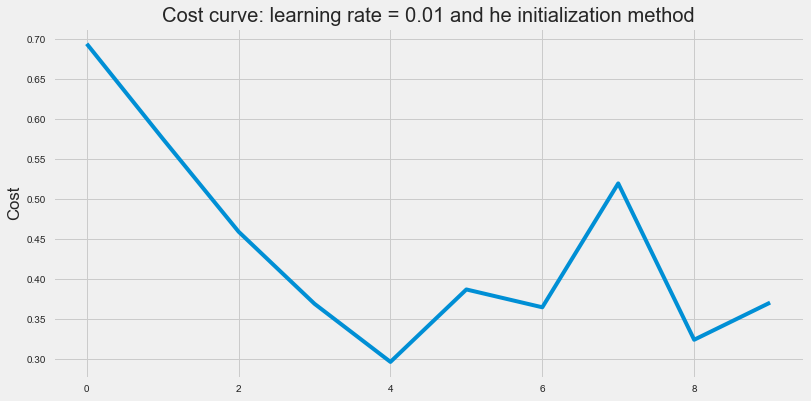

In [7]:
# train NN where all weights were initialized based on He recommendation
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh", initialization_method="he")

accuracy(X, parameters, Y, "tanh")

The cost after 100 iterations is: 0.6286352369571263
The cost after 200 iterations is: 0.4956771747746745
The cost after 300 iterations is: 0.3892768922807789
The cost after 400 iterations is: 0.5588701340708359
The cost after 500 iterations is: 0.5392550363953525
The cost after 600 iterations is: 0.38292089275935104
The cost after 700 iterations is: 0.20332983485328648
The cost after 800 iterations is: 0.12008486956170368
The cost after 900 iterations is: 0.08876538725802563
The cost after 1000 iterations is: 0.07171149201185487


'The accuracy rate is: 99.00%.'

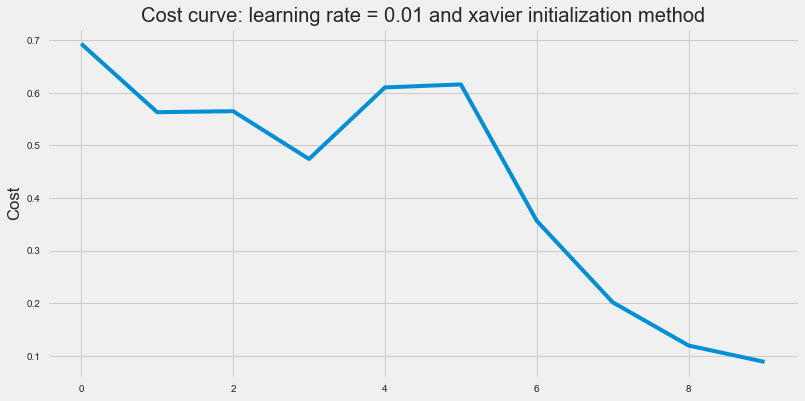

In [8]:
# train NN where all weights were initialized based on Xavier recommendation
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh", initialization_method="xavier")

accuracy(X, parameters, Y, "tanh")

As shown from applying the four methods, parameters' initial values play a huge role in achieving low cost values as well as converging and achieve lower training error rates. The same would apply to test error rate if we had test data.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2>

- Well chosen initialization values of weights leads to:
    - Speed up convergence of gradient descent.
    - Increase the likelihood of gradient descent to find lower training and generalization error rates.
- Different initializations lead to different results
- Random initialization is used to break symmetry and make sure different hidden units can learn different things
- Don't intialize to values that are too large
- Kaiming He (He) initialization works well for neural networks with ReLU activation function.
- Xavier initialization works well for neural networks with Hyperbolic Tangent activation function.